#### Carry out Tree based feature selection, feature selection with the Genetic Algorithm and LOSO with a ramdom forest classifier

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from parameter_feature_search import *
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#### We can choose to use just the protocol or just the optional datset

In [22]:
protocol_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/'
optional_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/'

In [24]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))+list(glob.glob(optional_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    subject_index = int(fname.split('/')[-1].split('.')[0][-1])
    dp = DP.dataprocess(fname,T=512,stride=512)
    
    #For LOSO, we need subjectID in the final dataframe
    dp.df['subjectID'] = int(subject_index)*np.ones(len(dp.df))
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

In [4]:
feature_df.to_csv("Features_df_with_subject.dat",index=False)

#### Load features dataframe

In [2]:
feature_df = pd.read_csv("Features_df_with_subject.dat")

In [3]:
Y = feature_df['activityID']
X = feature_df.drop(['activityID','subjectID'],axis=1)

#### Scale the input matrix and generate classification labels from the target column

In [4]:
sc = StandardScaler()
X_scaled = pd.DataFrame(sc.fit_transform(X),columns=X.columns)
le = LabelEncoder()
labels = le.fit_transform(Y)

#### Set up inputs for initial hyperparameter search function

In [5]:
model = RandomForestClassifier()

parameters = {
    'classify__n_estimators': (85,95,100,105,110),
    'classify__min_samples_leaf': (1,4,10),
    'classify__max_depth': (10,20,30,None),
    'classify__class_weight':("balanced","balanced_subsample",None),
    'classify__criterion':('gini','entropy')
}

#### Select optimal hyperparemeters and an estimate of the best feature columns

In [6]:
X_new, best_classifier = test_model_initial(model,X_scaled,labels,parameters)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (85, 95, 100, 105, 110), 'classify__min_samples_leaf': (1, 4, 10), 'classify__max_depth': (10, 20, 30, None), 'classify__class_weight': ('balanced', 'balanced_subsample', None), 'classify__criterion': ('gini', 'entropy')}
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 11.7min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 19.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 27.3min
[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed: 27.5min finished


done in 1653.876s

Best score: 0.990
Best parameters set:
	classify__class_weight: 'balanced'
	classify__criterion: 'entropy'
	classify__max_depth: 30
	classify__min_samples_leaf: 1
	classify__n_estimators: 105
Hold out score: 0.979


In [7]:
len(X_new.columns)

68

#### Select optimal feature columns using genetic algorithm

In [ ]:
GA = Run_GA(X_scaled,labels,best_classifier)

GeneticAlgorithm: Testing generation 1
GeneticAlgorithm: Testing generation 2
GeneticAlgorithm: Testing generation 3
GeneticAlgorithm: Testing generation 4
GeneticAlgorithm: Testing generation 5
GeneticAlgorithm: Testing generation 6
GeneticAlgorithm: Testing generation 7
GeneticAlgorithm: Testing generation 8
GeneticAlgorithm: Testing generation 9
GeneticAlgorithm: Testing generation 10
GeneticAlgorithm: Testing generation 11
GeneticAlgorithm: Testing generation 12
GeneticAlgorithm: Testing generation 13
GeneticAlgorithm: Testing generation 14
GeneticAlgorithm: Testing generation 15
GeneticAlgorithm: Testing generation 16
GeneticAlgorithm: Testing generation 17
GeneticAlgorithm: Testing generation 18
GeneticAlgorithm: Testing generation 19
GeneticAlgorithm: Testing generation 20
GeneticAlgorithm: Testing generation 21


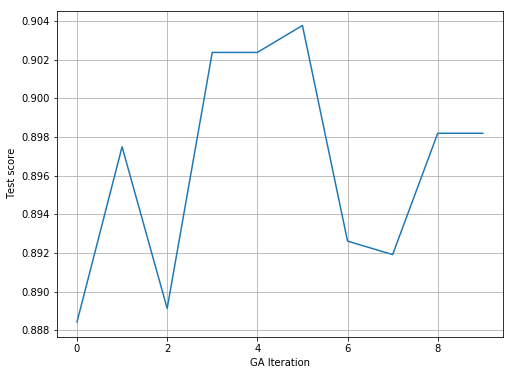

In [74]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(GA.fitness_evolution)
ax.set_xlabel('GA Iteration')
ax.set_ylabel('Test score')
plt.grid()

In [75]:
GA.best_fitness

0.898186889818689

In [76]:
len(GA.feature_selection.columns)

93

#### Do LOSO on the original feature columns 

In [105]:
X_features = X

sc = StandardScaler()
X_features_scaled = pd.DataFrame(sc.fit_transform(X_features),columns=X_features.columns)
X_features_scaled['activityID'] = X_features['activityID'].values
X_features_scaled['subjectID'] = X_features['subjectID'].values

In [106]:
subject_scores_no_selection = LOSO(X_features_scaled,best_classifier)

Holding out subject 6
Holding out subject 2
Holding out subject 9
Holding out subject 8
Holding out subject 3
Holding out subject 7
Holding out subject 5
Holding out subject 1
Holding out subject 4


In [107]:
subject_scores_no_selection

{'1.0': 0.41737649063032367,
 '2.0': 0.904320987654321,
 '3.0': 0.8071065989847716,
 '4.0': 0.9138576779026217,
 '5.0': 0.8159851301115242,
 '6.0': 0.8510158013544018,
 '7.0': 0.9630996309963099,
 '8.0': 0.7009708737864078,
 '9.0': 0.572139303482587}

In [108]:
mean_LOSO_no_selection = np.mean([subject_scores_no_selection[e] for e in list(subject_scores_no_selection.keys())])

#### Do LOSO on the feature columns selected by the GA

In [84]:
new_features_GA = list(GA.feature_columns) + ['activityID','subjectID']
X_feature_select_GA = feature_df[new_features_GA]

sc = StandardScaler()
X_feature_select_GA_scaled = pd.DataFrame(sc.fit_transform(X_feature_select_GA),columns=X_feature_select_GA.columns)
X_feature_select_GA_scaled['activityID'] = X_feature_select_GA['activityID'].values
X_feature_select_GA_scaled['subjectID'] = X_feature_select_GA['subjectID'].values

In [86]:
subject_scores_GA_selection = LOSO(X_feature_select_GA_scaled,best_classifier)

Holding out subject 1
Holding out subject 5
Holding out subject 8
Holding out subject 4
Holding out subject 6
Holding out subject 3
Holding out subject 2
Holding out subject 7
Holding out subject 9


In [87]:
subject_scores_GA_selection

{'1.0': 0.2928082191780822,
 '2.0': 0.6719745222929936,
 '3.0': 0.5817307692307693,
 '4.0': 0.49110320284697506,
 '5.0': 0.6431451612903226,
 '6.0': 0.5381263616557734,
 '7.0': 0.7676056338028169,
 '8.0': 0.5009784735812133,
 '9.0': 0.2961165048543689}

In [94]:
mean_LOSO_GA = np.mean([subject_scores_GA_selection[e] for e in list(subject_scores_GA_selection.keys())])

#### Do LOSO on the feature columns selected by the tree-based proceedure

In [109]:
new_features_Treebased = list(X_new.columns) + ['activityID','subjectID']
X_feature_select_Treebased = feature_df[new_features_Treebased]

sc = StandardScaler()
X_feature_select_Treebased_scaled = pd.DataFrame(sc.fit_transform(X_feature_select_Treebased),columns=X_feature_select_Treebased.columns)
X_feature_select_Treebased_scaled['activityID'] = X_feature_select_Treebased['activityID'].values
X_feature_select_Treebased_scaled['subjectID'] = X_feature_select_Treebased['subjectID'].values

In [110]:
subject_scores_Treebased_selection = LOSO(X_feature_select_Treebased,best_classifier)

Holding out subject 9
Holding out subject 3
Holding out subject 7
Holding out subject 6
Holding out subject 8
Holding out subject 1
Holding out subject 4
Holding out subject 5
Holding out subject 2


In [111]:
subject_scores_Treebased_selection

{'1.0': 0.42662116040955633,
 '2.0': 0.8973509933774835,
 '3.0': 0.7203791469194313,
 '4.0': 0.9442508710801394,
 '5.0': 0.7942307692307692,
 '6.0': 0.8705357142857143,
 '7.0': 0.868421052631579,
 '8.0': 0.6634050880626223,
 '9.0': 0.5330188679245284}

In [112]:
mean_LOSO_Treebased = np.mean([subject_scores_Treebased_selection[e] for e in list(subject_scores_Treebased_selection.keys())])

#### Compare final scores

In [113]:
print('Mean LOSO score for tree-based selection: %0.3f' %mean_LOSO_Treebased)
print('Mean LOSO score for GA-based selection: %0.3f' %mean_LOSO_GA)
print('Mean LOSO score for no feature selection: %0.3f' %mean_LOSO_no_selection)

Mean LOSO score for tree-based selection: 0.746
Mean LOSO score for GA-based selection: 0.532
Mean LOSO score for no feature selection: 0.772
